# What is DBSCAN?


Density-based Spatial Clustering of Applications with Noise Decision, commonly abbreviated as DBSCAN, is a common data clustering algorithm that is used in data mining and machine learning. DBSCAN is one of the most academically cited methods of clustering data. DBSCAN is especially potent on larger sets of data that have considerable noise; the algorithm works well on odd shaped datasets.


<img src = http://madhugnadig.com/articles/images/dbscananimation.gif>


DBSCAN is an unsupervised learning algorithm, ie. it needs no training data, it performs the computation on the actual dataset. This should be apparent from the fact that with DBSCAN, we are just trying to group similar data points into clusters, there is no prediction involved.


With DBSCAN, you don’t have to preemptively specify the number of clusters you want in the dataset, unlike k-means. All you need to provide is a value for minimum number of points in a given space and a distance value for what measure of distance is considered “close”.



<img src = http://madhugnadig.com/articles/images/dbscan.PNG>

## $\varepsilon$ Neighborhood

The $\varepsilon$ Neighborhood (Epsilon Neighborhood) is an important concept in the algorithm. Mathematically, it can be defined as:

- _The set of all points whose distance from a given point is less than some specified number epsilon._

The $\varepsilon$ Neighborhood of a point $p$ is a set of all points that are at most some $\varepsilon$ (with $\varepsilon > 0$) distance away from it. In a 2D space, such a locus is a circle, with the point p being the center of the circle. In a 3D space, that would be a sphere. Essentially, the $\varepsilon$ Neighborhood of a point p is the N Sphere with the point p as the center and the radius being $\varepsilon$.

Smaller the value of $\varepsilon$, the lesser the number of points in the neighborhood of $p$ and vise-versa.

## Density


Typically, density is $\frac{mass}{volume}$ in our case, given a point p we can define:

- Mass of the neighborhood: Number of data points in the neighborhood.

- Volume: Volume of the resultant shape of the $\varepsilon$ neighborhood. For a 2D dataset, this would be the area of the circle encapsulated by the $\varepsilon$ Neighborhood.

For example, let’s take the value of $\varepsilon$ as 0.5, and take the number of points in the neighborhood as 40, then we have:

$$Mass = 40$$
$$Volume = \pi * (0.5)^2$$
$$Density = \frac{40}{0.25 \pi} = 50.9$$


This value of density is meaningless in itself, but will play a very significant role in how we cluster the dataset using DBSCAN. In essence, what DBSCAN is actively looking for is dense neighborhoods, with most data points in a relatively small volume.

## How DBSCAN Works:


Now that we have the pre-requisites covered, we can jump right into the algorithm. DBSCAN takes in two parameters:

- $\varepsilon$ - The radius of the neighborhoods around any arbitrary data point.

- $minPoints$ - The minimum number of data points we want in a neighborhood to define a cluster.



Using these aforementioned data points, DBSCAN classifies each data point into one of three categories:


- Core point: A data point, $p$, is considered as a core point if the neighborhood at the distance $\varepsilon$ has at least $minPoints$ number of data points in it.



- Border point: A data point, $p$, is considered as a border point if the neighborhood at the distance $\varepsilon$ has less than $minPoints$ number of data points in it, but $p$ is reachable from at least one of the core points.


- Outliers: A data point $p$, is an outlier if the neighborhood at the distance $\varepsilon$ has less than $minPoints$ number of data points in it and $p$ is not reachable from any of the core points.


The following image illustrates these three types of categories.

<img src = http://madhugnadig.com/articles/images/dbscanpoints.png>


_In this diagram, minPts = 4. Point $A$ and the other red points are core points, because the area surrounding these points in an $\varepsilon$ radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points $B$ and $C$ are not core points, but are reachable from $A$ (via other core points) and thus belong to the cluster as well. Point $N$ is a noise point that is neither a core point nor directly-reachable._

#### Core Points

Since $\varepsilon$ is fixed (which means the volume is fixed) we essentially have a threshold on the _mass_. This forces a minimum density requirement on the cluster.

#### Border Points

Border points are not core points but are “Density Reachable” by other core points. Here, we have further have two categories of border points:

- Directly Density Reachable: A point $q$ is directly density-reachable from object $p$ if $p$ is a core point and $q$ is in the neighborhood of $p$.

<img src = http://madhugnadig.com/articles/images/DirectlyDensityReachable.png>


- Indirectly Density Reachable: A point $p$ is indirectly density-reachable from a point $q$ if $q$ is a core point, $p$ is not in the neighborhood of $q$ and $p$ is reachable by another core point, which is reachable by $q$.


<img src = http://madhugnadig.com/articles/images/IndirectlyDensityReachable.png>

## The Algorithm

Now, let’s list of the steps we’d do to cluster a data set through DBSCAN.

1. Sequentially pick points that have not been assigned to a cluster or named an outlier.

2. Compute its $\varepsilon$ neighborhood to see if it is a core point. If not assign it as an outlier (for now).

3. If it is a core point, label it as a cluster (this works since we sequentially go though the points which are already not part of a cluster). Add Directly Density Reachable neighbor points to its cluster.

4. Perform jumps from the neighborhood points to find all density reachable clusters (Indirect Density Reachable to the origin point). If there is any data point which is labeled as an outlier, change the status and assign it the current cluster - this points are our border points explained above.

5. Repeat the above 4 steps until each point in the dataset has either been assigned a cluster or has been marked as an outlier.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline

In [34]:
sns.set()

In [2]:
noisy_circles = datasets.make_circles(n_samples = 1500, factor = 0.5, noise = 0.08)

In [3]:
data = pd.DataFrame(noisy_circles[0], columns = ['x', 'y'])

In [4]:
data = pd.read_csv('donuts.csv')

In [5]:
data.head()

,x,y
0,-1.044310,-1.399915
1,-0.148713,-0.749795
2,-1.758723,-0.593306
3,-1.675720,0.434003
4,-0.511110,-0.199104


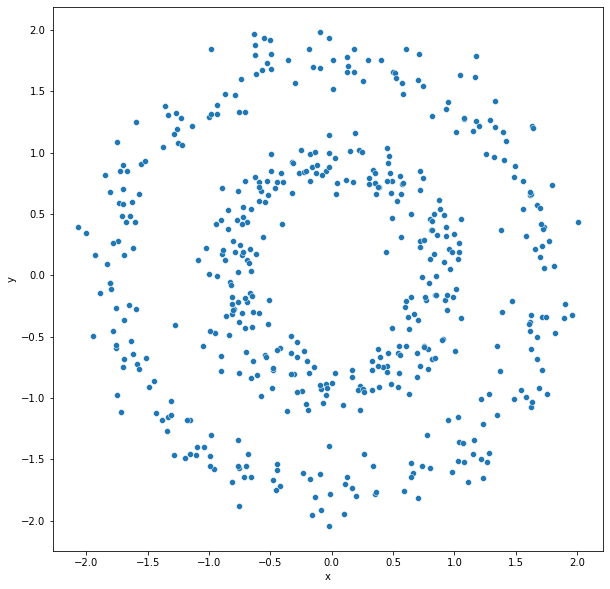

In [6]:
fig, ax = plt.subplots(figsize = (10, 10))

sns.scatterplot(data = data, x = 'x', y = 'y', ax = ax)
ax.set_aspect('equal');

In [7]:
class ClusterDBSCAN:
    
    def __init__(self, eps, min_pt):
        self.core   = -1
        self.border = -2
        self.eps    =  eps
        self.min_pt = min_pt
        
    
    def neighbour_points(self, data, point_index):
        points = []
        
        for i in range(len(data)):
            
            # Euclidian distance
            if np.linalg.norm([a_i - b_i for a_i, b_i in zip(data[i], data[point_index])]) <= self.eps:
                points.append(i)

        return points
    
    
    def fit(self, data):
        
        # initialize all points as outliers
        point_label      = [0] * data.shape[0] #0 for the outliers
        point_neighbours = []
        
        
        # initilize list for core/border points
        core = []
        border = []
        
        
        # Find the neighbours of each individual point
        for i in range(len(data)):
            point_neighbours.append(self.neighbour_points(data, i))
            
            
        # Find all the core points, border points and outliers
        for i in range(len(point_neighbours)):
            if (len(point_neighbours[i]) >= self.min_pt): 
                point_label[i] = self.core #core points labels
                core.append(i)
            
            else:
                border.append(i) 

        
        for i in border:
            
            for j in point_neighbours[i]:
                
                if j in core: #if there are a core point in the neighbours of i 
                    point_label[i] = self.border #then it's a corder point
                    break
        
        
        # Assign points to a cluster
        cluster = 1

        
        for i in range(len(point_label)):
            
            q = []
            
            if (point_label[i] == self.core):
                point_label[i] = cluster
                
                for x in point_neighbours[i]: #check the neighbours
                    
                    if(point_label[x] == self.core):
                        
                        q.append(x) #alll the core points in the cluster
                        point_label[x] = cluster #all core points in  the neighbour are the same cluster
                    
                    elif(point_label[x] == self.border):
                        point_label[x] = cluster #The border points in the neighbour also are in the cluster
                
                
                while len(q) != 0:
                    
                    neighbors = point_neighbours[q.pop(0)]
                    
                    for y in neighbors: #check the neighbours of the others core points in the cluster
                        
                        if (point_label[y] == self.core):
                            point_label[y] = cluster
                            q.append(y) #and this if for what we use the while and no the for
                        
                        if (point_label[y] == self.border):
                            point_label[y] = cluster
                
                
                cluster += 1  # Move on to the next cluster
                
        self.clusters = point_label
        self.clusters_number = cluster - 1
        

In [8]:
dbscan = ClusterDBSCAN(eps = 0.25, min_pt = 4)

In [9]:
X = data.values

In [10]:
dbscan.fit(X)

In [11]:
dbscan.clusters_number

2

In [12]:
set(dbscan.clusters)

{0, 1, 2}

In [13]:
dbscan.clusters;

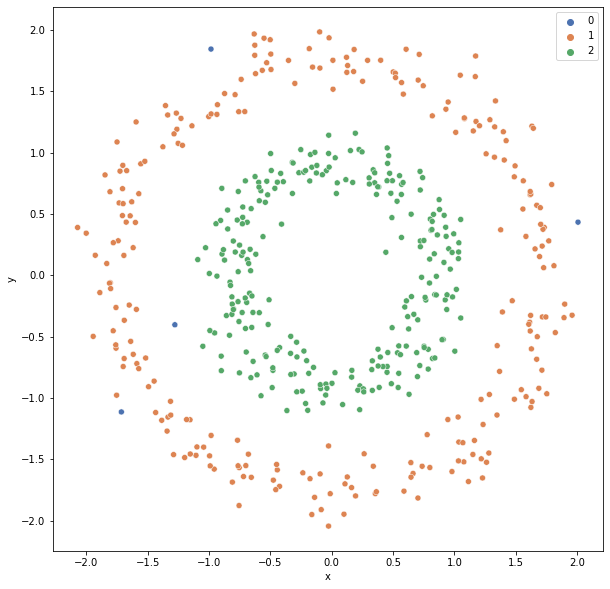

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))


sns.scatterplot(data = data, x = 'x', y = 'y', hue = dbscan.clusters, ax = ax, palette = "deep")
ax.set_aspect('equal');

In [15]:
from sklearn.neighbors import NearestNeighbors

In [16]:
nbrs = NearestNeighbors(n_neighbors = 4).fit(data)
distances, indices = nbrs.kneighbors(data)

In [17]:
distances.shape

(500, 4)

In [18]:
distances = distances[:, 1]
distances = np.sort(distances, axis=0, )

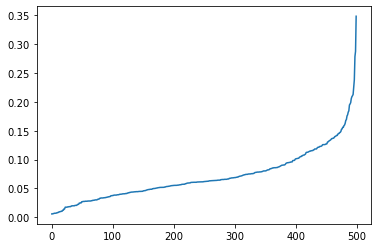

In [19]:
plt.plot(distances)

## K-means vs DBSCAN


In [20]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [21]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise = .05, random_state = 0)

In [22]:
labels = KMeans(2, random_state = 0).fit_predict(X)

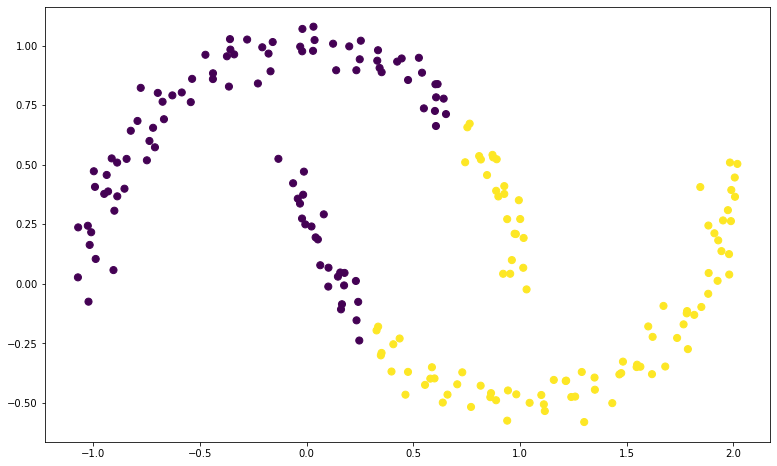

In [23]:
fig, ax = plt.subplots(figsize = (13, 8))

ax.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis');

In [25]:
labels = DBSCAN(eps = 0.25, min_samples = 5).fit_predict(X)

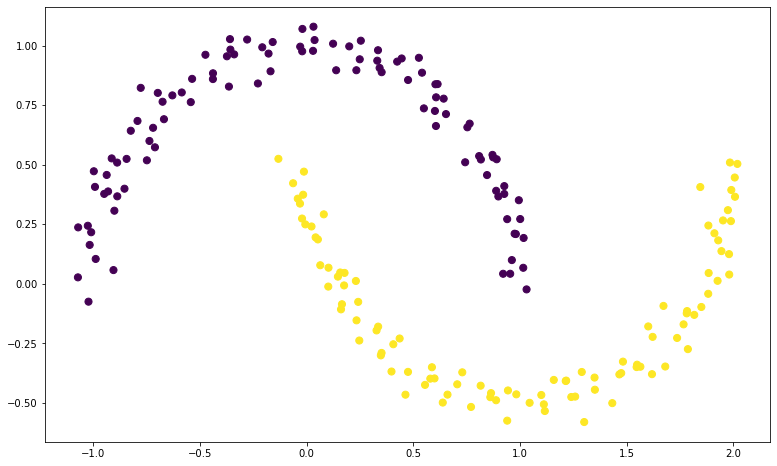

In [26]:
fig, ax = plt.subplots(figsize = (13, 8))

ax.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis');